In [1]:
import numpy as np
import sympy as sp
import sys
sys.path.append("../src/")

from MWPotential2014 import *
from matplotlib import pyplot as plt

# 1. Contruct transformation

## set up Hamiltonian object 

This sets up a `celmech.Hamiltonian` object representing the Hamiltonian of a particle in the `MWPotential2014` potential. This object will be used below to calculate derivatives of the effective potential and to directly integrate orbits.

In [2]:
Rc = 1 
L = 1
ham = MWPotential2014_get_hamiltonian_full([0,Rc,0,L,0,0])

`ham` stores a symbolic representation of the Hamiltonian, which we can see through the `ham.H` attribute:

In [3]:
ham.H

                                          ⎛       _________⎞                     ⎛       ⎛        2    2⎞                    ⎞       
                                          ⎜      ╱  2    2 ⎟                     ⎜       ⎜3   α  R  + z ⎟                    ⎟       
                                          ⎜    ╲╱  R  + z  ⎟                     ⎜  r_C⋅γ⎜─ - ─, ───────⎟                    ⎟       
                                    A₂⋅log⎜1 + ────────────⎟                     ⎜       ⎜2   2       2 ⎟    ⎛        2    2⎞⎟     2 
                 A₁                       ⎝         rₛ     ⎠             2    -α ⎜       ⎝         r_C  ⎠    ⎜    α  R  + z ⎟⎟    L  
- ─────────────────────────────── - ──────────────────────── + 2⋅π⋅A₃⋅r_C ⋅r_C  ⋅⎜- ───────────────────── + γ⎜1 - ─, ───────⎟⎟ + ────
       __________________________            _________                           ⎜          _________        ⎜    2       2 ⎟⎟      2
      ╱                        2            ╱  2    2         

## Compute values of $H_n$
Now we'll use `sympy` along with some utility functions to develop a series representation of the Hamiltonian in terms of the complex variables $x_R$ and $x_z$ and their complex conjugates.

In [4]:
from celmech.poisson_series import PoissonSeries
from SeriesUtils import PotentialDerivativesToPoissonSeries
from SeriesUtils import pert_series_to_PoissonSeries

In [5]:
_,R,z,_,pR,pz = ham.qp_vars
qp_rule = ham.qp
cvar_symbols = sp.symbols("x_R,x_z,xbar_R,xbar_z")

In [6]:
%%time
lmax = 10 # max order to carry out expansion
derivs = dict()
for n in range(2,lmax+1):
    for l in range(n+1):
        nR = n-l
        nz = l
        derivs[(nR,nz)]=float(sp.diff(ham.N_H,R,nR,z,nz).xreplace(qp_rule))        

CPU times: user 42 s, sys: 0 ns, total: 42 s
Wall time: 42.1 s


In [7]:
%%time
ham_series = PotentialDerivativesToPoissonSeries(derivs,lmax,cvar_symbols=cvar_symbols)

CPU times: user 7.59 ms, sys: 0 ns, total: 7.59 ms
Wall time: 7.17 ms


The dictionary `ham_series` contains terms in the expansion of the Hamiltonian up to the maximum user-specified order, `lmax`.

For example `ham_series[5]` stores, $H_5$, the terms appearing at order $5$ in the variables $(x_R,x_z,\bar{x}_R,\bar{x}_z)$. We can view it as an expression below:

In [8]:
ham_series[5].as_expression()

                       5                       4                            3    2                       3                           
- 0.244496805205513⋅x_R  - 1.22248402602757⋅x_R ⋅x̅_R - 0.827720219267203⋅x_R ⋅x_z  - 1.65544043853441⋅x_R ⋅x_z⋅x̅_z - 2.444968052055

    3    2                        3    2                       2    2                           2                                   2
13⋅x_R ⋅x̅_R  - 0.827720219267203⋅x_R ⋅x̅_z  - 2.48316065780161⋅x_R ⋅x_z ⋅x̅_R - 4.96632131560322⋅x_R ⋅x_z⋅x̅_R⋅x̅_z - 2.444968052055

    3                       2        2                           4                           3                               2    2  
13⋅x_R ⋅x̅_R  - 2.48316065780161⋅x_R ⋅x̅_R⋅x̅_z  + 36.9523987125367⋅x_R⋅x_z  + 147.809594850147⋅x_R⋅x_z ⋅x̅_z - 2.48316065780161⋅x_R⋅

                        2    2                               2                                   3                           4       
x_z ⋅x̅_R  + 221.71439227522⋅x_R⋅x_z ⋅x̅_z  - 4.96632131560

## compute $\chi$ and $H'$
The `celmech` function `poisson_series.birkhoff_normalize` carries out the Birkhoff normalization process up to a user-specified order.

In [9]:
from celmech.poisson_series import birkhoff_normalize

The `birkhoff_normalize` function takes the small oscillation frequencies as input. Below, The variable `omega` is assigned the value $(\kappa,\nu)$.

In [10]:
omega = np.array((ham_series[2][(1,0,1,0)],ham_series[2][(0,1,0,1)]))
omega = np.real(omega)
omega

array([1.34095965, 2.72554058])

The `birkhoff_normalize` retuns the generating function, $\chi$, and the transformed Hamiltonian, $H'$ as dictionaries with terms grouped by order.

In [11]:
chi, ham1_series = birkhoff_normalize(omega,ham_series,lmax)

# 2. Compute $(x,v)\rightarrow (J,\theta)$
Construct series for 
$$
x'_i = \exp[-\mathcal{L}_\chi]x_i
$$

In [12]:
from celmech.poisson_series import expLinv
from SeriesUtils import get_xseries, to_pade2_approx_function
from celmech.poisson_series import PSTerm

Series representations of $x_R$ and $x_z$

In [13]:
xR_series, xz_series = get_xseries(2)
xR_series[1].as_expression(),xz_series[1].as_expression()

(1.0⋅z₁, 1.0⋅z₂)

Series representations of $x_R'$ and $x_z'$ are polynomials of degree $l_\mathrm{max}-1$. `expLinv` returns these as dictionaries with terms grouped by order.

In [14]:
xR_prime_series,xz_prime_series = [expLinv(xi_series,chi) for xi_series in (xR_series, xz_series)]

We can convert these grouped dictionaries to functions that can be evaluated as functions of input values, $x_R,x_z$

In [15]:
def pert_series_to_function(pert_series):
    """
    Convert a dictionary with PoissonSeries entries grouped by order into a function.
    """
    series  = pert_series_to_PoissonSeries(pert_series)
    exprn = series.as_expression()
    f = sp.lambdify(series.cvar_symbols,exprn)
    return (lambda xR,xz: f(xR,xz,np.conjugate(xR),np.conjugate(xz)))    
xR_osc_to_mean_taylor,xz_osc_to_mean_taylor = [pert_series_to_function(xi_series) for xi_series in (xR_prime_series,xz_prime_series)]

Construct (2,n) Pade approximants for $x_R'$ by grouping terms in powers of $I_z$ using the functions `to_pade2_approx_function` defined in `SeriesUtils`

In [16]:
series = pert_series_to_PoissonSeries(xR_prime_series)
_xR_func = to_pade2_approx_function(series)
xR_osc_to_mean_pade2 =  lambda xR,xz: _xR_func(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

Consruct (2,n) Pade approximants for the polynmoial $P$ in $x_z' =x_z P(x_R,x_z,\bar{x}_R,\bar{x}_z)$ by grouping terms in powers of $I_z$.

In [17]:
series = pert_series_to_PoissonSeries(xz_prime_series)
newterms = [PSTerm(term.C,term.k-np.array((0,1)),term.kbar,term.p,term.q) for term in series.terms]
xz_osc_to_mean_by_xz = PoissonSeries.from_PSTerms(newterms)
_xz_func = to_pade2_approx_function(xz_osc_to_mean_by_xz)
xz_osc_to_mean_pade2 = lambda xR,xz: xz * _xz_func(xR,np.conjugate(xR),np.abs(xz)**2,xz/np.abs(xz))

## Integrate an orbit

Integration loop

In [18]:
vc=L/Rc

phi0,R0,z0, = 0., Rc, 0, 
L0,pR0,pz0 = L, 0.15 * vc , 0.05 * vc
x0 = [phi0,R0,z0,L0,pR0,pz0]
ham.state.t = 0.
ham.state.values = x0
Nout = 4*128
orbit = np.zeros((Nout,ham.N_dim))
times = np.linspace(0,5,Nout) * 2*np.pi/np.min(omega)
for i,t in enumerate(times):
    ham.integrate(t)
    orbit[i] = ham.state.values

Compute actions

In [19]:
iR = ham.qp_vars.index(R)
iz = ham.qp_vars.index(z)
ipR = iR + ham.N_dof
ipz = iz + ham.N_dof
xR_values = np.sqrt(0.5*omega[0]) * ((orbit.T[iR]-Rc) + 1j * orbit.T[ipR]/omega[0])
xz_values = np.sqrt(0.5*omega[1]) * ((orbit.T[iz]) + 1j * orbit.T[ipz]/omega[1])

def get_action(xi_prime_func,xR,xz):
    xi_prime = xi_prime_func(xR,xz)
    return np.abs(xi_prime)**2

proj_xR = lambda xR,xz: xR
proj_xz = lambda xR,xz: xz

IR,JR_taylor,JR_pade = [get_action(f,xR_values,xz_values) for f in (proj_xR,xR_osc_to_mean_taylor, xR_osc_to_mean_pade2)]
Iz,Jz_taylor,Jz_pade = [get_action(f,xR_values,xz_values) for f in (proj_xz,xz_osc_to_mean_taylor, xz_osc_to_mean_pade2)]


Plot

Text(0, 0.5, '$\\Delta J_z / J_Z$')

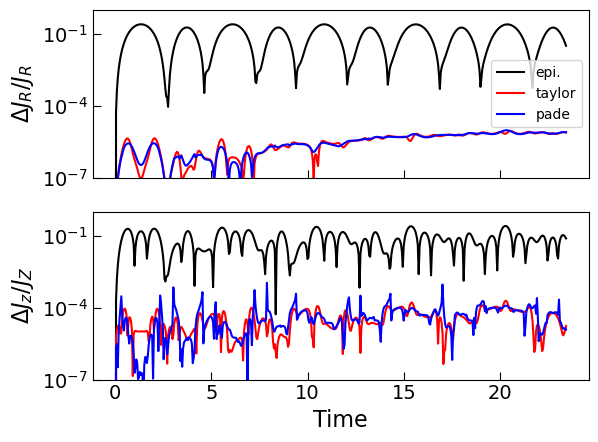

In [20]:
fig,ax = plt.subplots(2,1,sharex=True)


for i,J in enumerate([IR,JR_taylor,JR_pade]):
    lbl=('epi.','taylor','pade')[i]
    ax[0].plot(times,np.abs(J/J[0]-1),color='krb'[i],label=lbl)
for i,J in enumerate([Iz,Jz_taylor,Jz_pade]):
    ax[1].plot(times,np.abs(J/J[0]-1),color='krb'[i])
ax[0].legend()
for a in ax:
    plt.sca(a)
    plt.yscale('log')
    plt.ylim(1e-7,1)
    plt.tick_params(labelsize = 14,direction='in',size=6)
    plt.tick_params(which='minor',direction='in',size=4)
ax[1].set_xlabel("Time",fontsize=16)
ax[0].set_ylabel(r"$\Delta J_R / J_R$",fontsize=16)
ax[1].set_ylabel(r"$\Delta J_z / J_Z$",fontsize=16)



# 3. Predict orbit using $(J,\theta)\rightarrow (x,v)$
Here we'll construct the explicit transformation from AA variables to Cartesian data in order to predict analytically the numerically integrated orbit found above. The inverse transformation will use the fact that 
$$
x_i(x'_R,x'_z,\bar{x}'_R,\bar{x}'_z)=(\exp[\mathcal{L}_\chi]x'_i)(x'_R,x'_z,\bar{x}'_R,\bar{x}'_z)~.
$$
We'll use the `celmech` function `poisson_series.expL` to get a series approximation of the r.h.s. of this equation.

In [21]:
from SeriesUtils import h_series_to_omega_series
from celmech.poisson_series import expL

In [22]:
xR_series,xz_series = get_xseries(2)
xR_of_xprime,xz_of_xprime = [expL(xi_series,chi) for xi_series in get_xseries(2)]

As above, we'll convert each of these dictionaries, the entries of which hold terms of a given order, into a functions that we can evaluate for speicifc values of $x'_R$ and $x'_z$. These series will allow us to go from "mean" variables to osculating ones.

In [23]:
xR_mean_to_osc, xz_mean_to_osc = [pert_series_to_function(xi_series) for xi_series in (xR_of_xprime,xz_of_xprime)]

The Hamiltonian, $H'(J_R,J_z)$ is used to get $\Omega_R(J_R,J_z)$ and $\Omega_z(J_R,J_z)$ using the `h_series_to_omega_series` function.

In [24]:
ham1 = pert_series_to_PoissonSeries(ham1_series)
Omega_R_series,Omega_z_series = h_series_to_omega_series(ham1)

In [25]:

# initial values of x'_R and x'_z
xR_prime0 = xR_osc_to_mean_taylor(xR_values[0],xz_values[0])
xz_prime0 = xz_osc_to_mean_taylor(xR_values[0],xz_values[0])

# Numerical values of frequencies
x0 = (xR_prime0,xz_prime0)
NOmega_R = Omega_R_series(x0,[],[])
NOmega_z = Omega_z_series(x0,[],[])
print("Omega_R = {0.real:.5f}, Omega_z = {1.real:0.5f}".format(NOmega_R,NOmega_z))

Omega_R = 1.32072, Omega_z = 2.56943


Predicted orbit according to the epicyclic approximation

In [26]:
xR_predicted_epi = xR_values[0] * np.exp(- 1j * omega[0] * times)
xz_predicted_epi = xz_values[0] * np.exp(- 1j * omega[1] * times)

Predict orbit using
$$x_i\left(x'_{R,0}e^{-i\Omega_R t} ,x'_{z,0}e^{-i\Omega_zt} ,\bar{x}'_{R,0}e^{i\Omega_Rt} ,\bar{x}'_{z,0}e^{i\Omega_zt} \right)$$

In [27]:
xR_predicted_taylor = xR_mean_to_osc(
    xR_prime0 * np.exp(- 1j * NOmega_R * times),
    xz_prime0 * np.exp(- 1j * NOmega_z * times)
)
xz_predicted_taylor = xz_mean_to_osc(
    xR_prime0 * np.exp(- 1j * NOmega_R * times),
    xz_prime0 * np.exp(- 1j * NOmega_z * times)
)

Plot orbits

Text(0.5, 0, 'Time')

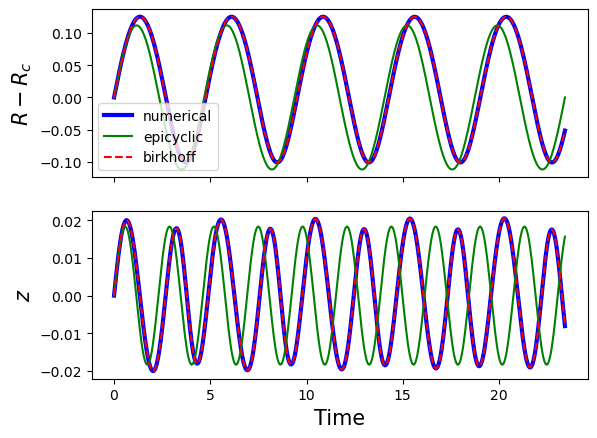

In [28]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(times, orbit.T[iR]-Rc,'b-',lw=3,label='numerical')
ax[0].plot(times, np.real(xR_predicted_epi)* np.sqrt(2/omega[0]),'g-',label='epicyclic')
ax[0].plot(times, np.real(xR_predicted_taylor)* np.sqrt(2/omega[0]),'r--',label='birkhoff')
ax[0].set_ylabel("$R-R_c$",fontsize=15)
ax[0].legend(loc='lower left')

ax[1].plot(times, orbit.T[iz],'b-',lw=3)
ax[1].plot(times, np.real(xz_predicted_epi) * np.sqrt(2/omega[1]),'g-')
ax[1].plot(times, np.real(xz_predicted_taylor)* np.sqrt(2/omega[1]),'r--')
ax[1].set_ylabel("$z$",fontsize=15)
ax[1].set_xlabel("Time",fontsize=15)

# 4. Compute  $\Omega_\phi$

In [29]:
from SeriesUtils import generate_phidot_series

Create a `defaultdict` representing an series expansion of 
$$ 
\frac{d\phi}{dt} = \frac{L}{R^2} = \frac{L}{\left(R_c + \frac{1}{\sqrt{2\kappa}}(x_R+\bar{x}_R)\right)^2}
$$

Text(0.5, 0, 'Time')

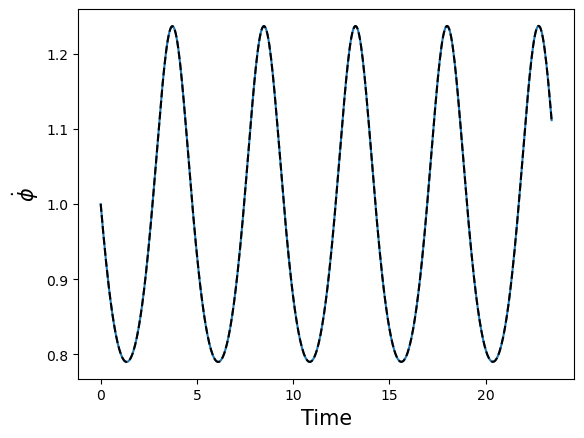

In [30]:
phi_dot_series = generate_phidot_series(Rc,L,omega[0],lmax)
phi_dot_fn = pert_series_to_function(phi_dot_series)
Omega_phi0 = L / Rc / Rc 

Omega_phi = phi_dot_fn(xR_values,xz_values)
# should be real-valued
assert np.alltrue(np.isclose(np.imag(Omega_phi),0))
Omega_phi = np.real(Omega_phi)

plt.plot(times,L/orbit.T[iR]/orbit.T[iR],label='numerical')
plt.plot(times,Omega_phi,'k--',label='series')
plt.ylabel(r"$\dot\phi$",fontsize=15)
plt.xlabel("Time",fontsize=15)

Express $\frac{d\phi}{dt}$ as a function of transformed variables $x'_R,x'_z$ according to
$$
\frac{d\phi}{dt} = \frac{L}{R_c^2}
\left(
    \exp[\mathcal{L}_\chi]
    \left(1 + \frac{x_R+\bar{x}_R}{R_c\sqrt{2\kappa}}\right)^{-2}
\right)(x'_R,x'_z,\bar{x}'_R,\bar{x}'_z)
$$
then separate into "mean" and "oscillating" terms to define $\Omega_\phi$ and $\frac{d}{dt}\rho$ where 
$$
\theta_\phi = \phi_0 + \Omega_\phi t + \rho
$$

In [31]:
phi_dot_of_xprime = expL(phi_dot_series,chi)
mean_terms = []
osc_terms = []
Omega_phi0 = L/Rc/Rc
for key,val in phi_dot_of_xprime.items():
    for term in val.terms:
        if np.alltrue(np.equal(term.k , term.kbar)):
            mean_terms.append(term)
        else:
            denom = 1j * (term.kbar-term.k) @ omega
            newterm=PSTerm(term.C / denom,term.k,term.kbar,term.p,term.q)
            osc_terms.append(newterm)
            
phi_dot = PoissonSeries.from_PSTerms(mean_terms)
Omega_phi_taylor = np.real(phi_dot([xR_prime0,xz_prime0],[],[]))

Predict time evolution of azimuthal angle, $\phi$

In [32]:
osc_series = PoissonSeries.from_PSTerms(osc_terms)
#osc_func = pert_series_to_function(osc_series)

osc_func = sp.lambdify(osc_series.cvar_symbols,osc_series.as_expression())
osc_fn = lambda xR,xz: osc_func(xR,xz,np.conjugate(xR),np.conjugate(xz))

delta_phi = osc_fn(
    xR_prime0 * np.exp(- 1j * NOmega_R * times),
    xz_prime0 * np.exp(- 1j * NOmega_z * times)
      ) 
assert np.allclose(np.imag(delta_phi),0)
delta_phi = np.real(delta_phi)


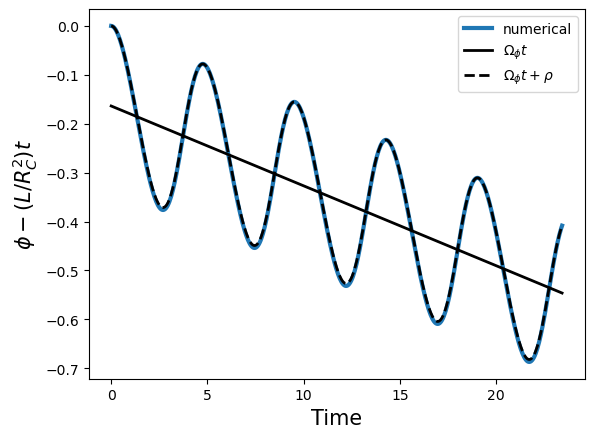

In [33]:
phi0 = orbit.T[0,0]  - delta_phi[0]

plt.plot(times,orbit.T[0] - L*times/Rc/Rc,lw=3,label="numerical")
plt.plot(times, (Omega_phi_taylor - Omega_phi0) * times + phi0,'k-',lw=2,label=r"$\Omega_\phi t$")
plt.plot(times, (Omega_phi_taylor - Omega_phi0) * times + delta_phi + phi0,'k--',lw=2,label=r"$\Omega_\phi t + \rho$")
plt.ylabel(r"$\phi - (L/R_C^2)t$",fontsize=15)
plt.xlabel("Time",fontsize=15)
plt.legend()